In [2]:
import numpy as np
import math, random

from math import sqrt, pi, atan2, cos, sin

import matplotlib.pyplot as plt

from typing import List, Tuple

from shapely import affinity
from shapely.geometry import Polygon, Point, LinearRing, LineString
from shapely.plotting import plot_polygon, plot_points, plot_line
from shapely.ops import transform

Creating polygon

Model 4

In [3]:
def generate_polygon(center: Tuple[float, float], avg_radius: float,
                     irregularity: float, spikiness: float,
                     num_vertices: int) -> List[Tuple[float, float]]:
    """
    Start with the center of the polygon at center, then creates the
    polygon by sampling points on a circle around the center.
    Random noise is added by varying the angular spacing between
    sequential points, and by varying the radial distance of each
    point from the centre.

    Args:
        center (Tuple[float, float]):
            a pair representing the center of the circumference used
            to generate the polygon.
        avg_radius (float):
            the average radius (distance of each generated vertex to
            the center of the circumference) used to generate points
            with a normal distribution.
        irregularity (float):
            variance of the spacing of the angles between consecutive
            vertices.
        spikiness (float):
            variance of the distance of each vertex to the center of
            the circumference.
        num_vertices (int):
            the number of vertices of the polygon.
    Returns:
        List[Tuple[float, float]]: list of vertices, in CCW order.
    """
    # Parameter check
    if irregularity < 0 or irregularity > 1:
        raise ValueError("Irregularity must be between 0 and 1.")
    if spikiness < 0 or spikiness > 1:
        raise ValueError("Spikiness must be between 0 and 1.")

    irregularity *= 2 * math.pi / num_vertices
    spikiness *= avg_radius
    angle_steps = random_angle_steps(num_vertices, irregularity)

    # now generate the points
    points = []
    angle = random.uniform(0, 2 * math.pi)
    for i in range(num_vertices):
        radius = clip(random.gauss(avg_radius, spikiness), 0, 2 * avg_radius)
        point = (center[0] + radius * cos(angle),
                 center[1] + radius * sin(angle))
        points.append(point)
        angle += angle_steps[i]

    return points

In [4]:
def random_angle_steps(steps: int, irregularity: float) -> List[float]:
    """Generates the division of a circumference in random angles.

    Args:
        steps (int):
            the number of angles to generate.
        irregularity (float):
            variance of the spacing of the angles between consecutive vertices.
    Returns:
        List[float]: the list of the random angles.
    """
    # generate n angle steps
    angles = []
    lower = (2 * math.pi / steps) - irregularity
    upper = (2 * math.pi / steps) + irregularity
    cumsum = 0
    for i in range(steps):
        angle = random.uniform(lower, upper)
        angles.append(angle)
        cumsum += angle

    # normalize the steps so that point 0 and point n+1 are the same
    cumsum /= (2 * math.pi)
    for i in range(steps):
        angles[i] /= cumsum
    return angles

In [5]:
def clip(value, lower, upper):
    """
    Given an interval, values outside the interval are clipped to the interval
    edges.
    """
    return min(upper, max(value, lower))

In [6]:
x0, y0, R = 2.0, -1.0, 1.0
vertices = generate_polygon(center=(x0, y0),
                            avg_radius=4,
                            irregularity=0.05,
                            spikiness=0.1,
                            num_vertices=7)
pplg = LinearRing(vertices)

Solution

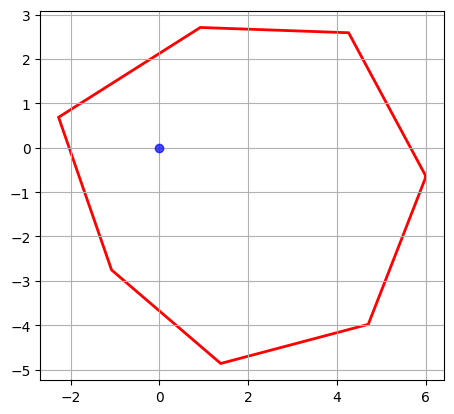

In [7]:
ppts = []
ppts.append(Point(pplg.coords[0][0], pplg.coords[0][1]))
for i in reversed(range(len(pplg.coords)-1)):
    ppts.append(Point(pplg.coords[i][0], pplg.coords[i][1]))
plg = LinearRing(ppts)

plot_line(plg, add_points=False, color=(1,0,0), alpha=1)
plot_points(Point(0.0, 0.0), color=(0,0,1), alpha=0.7)

plt.autoscale()
plt.show()

In [8]:
edg = []
trcpts = []

for i in range(len(plg.coords)-1):
    r = sqrt((plg.coords[i+1][0]-plg.coords[i][0])**2+(plg.coords[i+1][1]-plg.coords[i][1])**2)
    edg.append(((plg.coords[i+1][0]-plg.coords[i][0])/r, (plg.coords[i+1][1]-plg.coords[i][1])/r, r))

for i in range(len(plg.coords)-1):
    trcpts.append(Point(plg.coords[i][0]-edg[i][1]*R, plg.coords[i][1]+edg[i][0]*R))
    trcpts.append(Point(plg.coords[i+1][0]-edg[i][1]*R, plg.coords[i+1][1]+edg[i][0]*R))

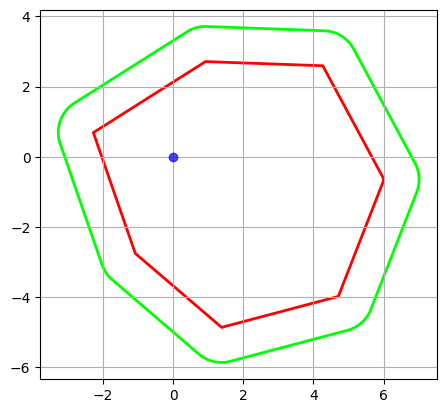

In [9]:
pts = []

lines = []
circles = []

for i in range(0, len(trcpts)-1, 2):
    n = 1000
    # line
    pt1 = trcpts[i]
    pt2 = trcpts[i+1]
    # line = []
    for j in range(n): 
        alpha = j / n
        x = (1-alpha)*pt1.x+alpha*pt2.x
        y = (1-alpha)*pt1.y+alpha*pt2.y
        # line.append((x, y))
        pts.append(Point(x, y))
    # lines.append(line)

    n = 10000
    # circle
    pt1 = trcpts[i+1]
    if i+2 == len(trcpts):
        pt2 = trcpts[0]
    else:
        pt2 = trcpts[i+2]
    angle1 = atan2(pt1.y-plg.coords[int((i+2)/2)][1], pt1.x-plg.coords[int((i+2)/2)][0])
    angle2 = atan2(pt2.y-plg.coords[int((i+2)/2)][1], pt2.x-plg.coords[int((i+2)/2)][0])
    if angle1 < 0.0 and angle2 > 0.0:
        angle2 -= 2.0*math.pi
    # circle = []
    for j in range(n): 
        alpha = j / n
        phi = (1-alpha)*angle1+alpha*angle2
        x = R*cos(phi)+plg.coords[int((i+2)/2)][0]
        y = R*sin(phi)+plg.coords[int((i+2)/2)][1]
        # circle.append((x, y))
        pts.append(Point(x, y))
    # circles.append(circle)

trc = LinearRing(pts)

plot_line(plg, add_points=False, color=(1,0,0), alpha=1)
plot_line(trc, add_points=False, color=(0,1,0), alpha=1)
plot_points(Point(0.0, 0.0), color=(0,0,1), alpha=0.7)

plt.rcParams["figure.figsize"] = [5.0, 5.00]
plt.autoscale()
plt.show()

In [ ]:
# for line in lines:
#     plt.scatter(*zip(*line), s=0.01)

# for circle in circles:
#     plt.scatter(*zip(*circle), s=0.01)
    
# plt.rcParams["figure.figsize"] = [5.0, 5.00]
# plt.gca().set_aspect('equal')
# plt.show()

In [10]:
ln = LineString([(0.0, 0.0), (0.0, 100.0)])
x = []
y = []
n = 1000
for i in range(n):
    angle = i*360.0/n
    yval = affinity.rotate(trc, angle, origin=Point(0.0,0.0)).intersection(ln).y
    x.append(angle)
    y.append(yval)

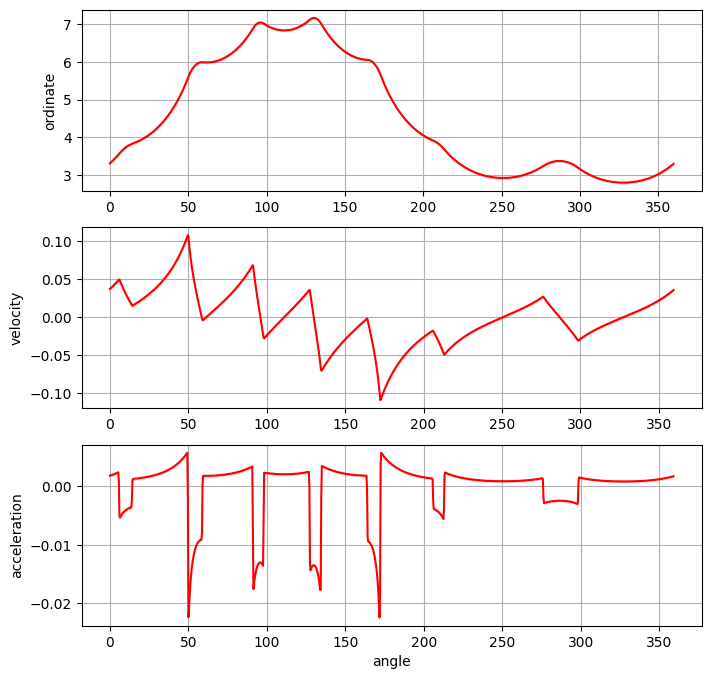

In [11]:
d1 = [(y2-y0)/(x2-x0) for x2, x0, y2, y0 in zip(x[1:], x, y[1:], y)]
d2 = [(y2-y0)/(x2-x0) for x2, x0, y2, y0 in zip(x[1:], x, d1[1:], d1)]

fig, axs = plt.subplots(3, 1)
fig.set_size_inches(8.0, 8.0)

axs[0].plot(x, y, marker='.', color="red", markersize=0.1)
axs[0].set_ylabel('ordinate')
axs[0].grid(True)

axs[1].plot(x[:-1], d1, marker='.', color="red", markersize=0.1)
axs[1].set_ylabel('velocity')
axs[1].grid(True)

axs[2].plot(x[:-2], d2, marker='.', color="red", markersize=0.1)
axs[2].set_xlabel('angle')
axs[2].set_ylabel('acceleration')
axs[2].grid(True)

plt.show()